# Predicting numberplate price, naively.

A naive attempt at predicting Dubai car number plate prices using simple ML models.

Data scraped from https://www.plates.ae/plates-en/plate.php

In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import re

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10,5]

### Load data

In [2]:
plates = pd.read_csv('num_plates.csv')
plates = plates[['Number', 'Code', 'Price']]
plates.head(10)

,Number,Code,Price
0,274,I,"215,000AED"
1,78888,H,"72,000AED"
2,6777,K,"72,000AED"
3,3334,R,"72,000AED"
4,22232,N,"41,000AED"
5,80088,L,"25,000AED"
6,20220,K,"24,000AED"
7,22002,K,"24,000AED"
8,30033,P,"24,000AED"
9,1160,U,"21,000AED"


### Data preprocessing

In [3]:
plates['Price'] = plates['Price'].apply(lambda x: re.sub(r"[a-zA-Z,]",'',x)).astype(int)
plates['Full_plate'] = plates['Code'] + '-' +  plates['Number'].astype(str)

In [4]:
#Encode categorical values, turns letters into numbers
label_encoder = LabelEncoder()
plates['Code_encoded'] = label_encoder.fit_transform(plates['Code'])

#Mapping to use later for single data point prediction
label_map = {k:v for k,v in zip(label_encoder.classes_,range(len(label_encoder.classes_)))}
label_map

{'A': 0,
 'B': 1,
 'D': 2,
 'E': 3,
 'G': 4,
 'H': 5,
 'I': 6,
 'J': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'O': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'U': 18,
 'V': 19,
 'W': 20}

In [5]:
plates.head(10)

,Number,Code,Price,Full_plate,Code_encoded
0,274,I,215000,I-274,6
1,78888,H,72000,H-78888,5
2,6777,K,72000,K-6777,8
3,3334,R,72000,R-3334,15
4,22232,N,41000,N-22232,11
5,80088,L,25000,L-80088,9
6,20220,K,24000,K-20220,8
7,22002,K,24000,K-22002,8
8,30033,P,24000,P-30033,13
9,1160,U,21000,U-1160,18


### Dataset info

In [6]:
plates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Number        1457 non-null   int64 
 1   Code          1457 non-null   object
 2   Price         1457 non-null   int32 
 3   Full_plate    1457 non-null   object
 4   Code_encoded  1457 non-null   int32 
dtypes: int32(2), int64(1), object(2)
memory usage: 45.7+ KB


## EDA

In [7]:
plates_plot = plates[['Number','Price','Code']]
plates_plot['Number'] = plates_plot['Number'].astype(str)
plates_plot['n_l'] = plates_plot['Number'].apply(lambda x: len(x))
plates_plot.head()

,Number,Price,Code,n_l
0,274,215000,I,3
1,78888,72000,H,5
2,6777,72000,K,4
3,3334,72000,R,4
4,22232,41000,N,5


In [8]:
plates_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Number  1457 non-null   object
 1   Price   1457 non-null   int32 
 2   Code    1457 non-null   object
 3   n_l     1457 non-null   int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 40.0+ KB


### Number of digits

Text(0, 0.5, 'Count')

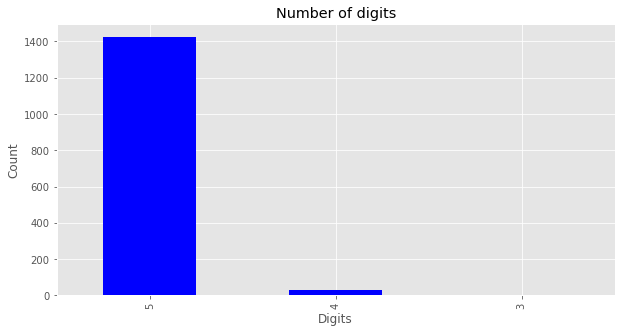

In [9]:
plates_plot['n_l'].value_counts().plot(kind = 'bar', color = 'blue')
plt.title('Number of digits')
plt.xlabel('Digits')
plt.ylabel('Count')

### Average price by # of digits

Text(0, 0.5, 'Digit (#)')

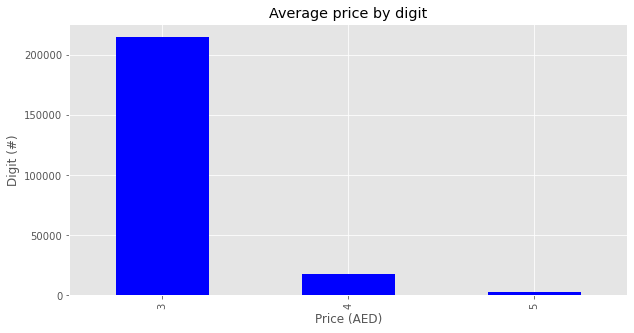

In [10]:
plates_plot.groupby(['n_l'])['Price'].mean().plot(kind = 'bar', color = 'blue')
plt.title('Average price by digit')
plt.xlabel('Price (AED)')
plt.ylabel('Digit (#)')

### Average price by letter

Text(0, 0.5, 'Average price (AED)')

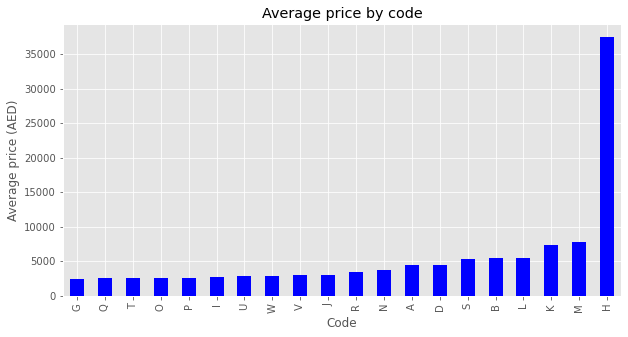

In [11]:
only_fives = plates_plot.loc[plates_plot['n_l'] == 5]

b_plot = only_fives.groupby(['Code'])['Price'].mean().sort_values()

b_plot.plot(kind = 'bar', color = 'blue')
plt.title('Average price by code')
plt.xlabel('Code')
plt.ylabel('Average price (AED)')

# Testing the different ML models

In [12]:
# Create X and Y
y = plates['Price']
features = ['Number','Code_encoded']
X = plates[features]

# Create the test train split
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [13]:
'''
Helper function to help train and evaluate models
Keep in mind this is VERY SIMPLE and just for testing, if we want to make things accurate..
We are going to have to do a lot more work, but at the end maybe we can
Squeeze out 3-4% more performance which I don't think is worth it.

'''
def test(model):
    model.fit(train_X, train_y)
    y_pred = model.predict(val_X)

    print(f'Mean absolute error = {mean_absolute_error(val_y, y_pred):.2f} AED')
    print(f'RMSE = {mean_squared_error(val_y, y_pred, squared = 0):.2f} AED')
    print(f'Model accuracy = {(1 - mean_absolute_percentage_error(val_y, y_pred))*100:.2f} %')

##### Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state=1)
test(forest_model)

Mean absolute error = 1109.79 AED
RMSE = 5973.19 AED
Model accuracy = 89.08 %


##### XGB

In [15]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
test(xgb_model)

Mean absolute error = 971.55 AED
RMSE = 5520.14 AED
Model accuracy = 89.58 %


##### Lin Reg

In [16]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()
test(linear_reg_model)

Mean absolute error = 2005.28 AED
RMSE = 5871.27 AED
Model accuracy = 52.26 %


##### Decision Tree

In [17]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
test(tree_model)

Mean absolute error = 1079.45 AED
RMSE = 2952.24 AED
Model accuracy = 88.17 %


##### Neural network

In [18]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
test(nn_model)

Mean absolute error = 1269.04 AED
RMSE = 3758.14 AED
Model accuracy = 87.38 %


##### KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
test(knn_model)

Mean absolute error = 1032.60 AED
RMSE = 2732.60 AED
Model accuracy = 89.44 %


##### Ada boost

In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=100, random_state=0)
test(ada_model)

Mean absolute error = 1004.66 AED
RMSE = 2776.23 AED
Model accuracy = 89.87 %


__________________________________________________________

It seems to be XGBoost is the best model for predicting large values and Decision tree for small values. Given the MAE and RMSE values relatively.

So for values 5 digit plates I will use a decision tree and for below use XGBoost

TODO: Optimize the model and the preprocessing steps further.

_________________________________________

## Initial testing

In [32]:
def predict_price(platenumber):
    
    XGB = 0
    
    num_split = platenumber.split('-')
    
    if len(num_split[1]) > 5:
        return 'Invalid number plate'
    
    if len(num_split[1]) != 5:
        XGB = 1
    
    number = int(num_split[1])
    code = num_split[0]
    
    letter_num = label_map[code]
    
    d = {'Number': [number],
        'Code_encoded': [letter_num]}
    val_X = pd.DataFrame(data = d)
    
    return_value = xgb_model.predict(val_X)[0]\
                    if XGB else tree_model.predict(val_X)[0]

    return f'Predicted price for plate {code}-{number} is {return_value:.2f} AED'        

In [33]:
predict_price('A-12345')

'Predicted price for plate A-12345 is 4500.00 AED'

In [36]:
predict_price('A-10000')

'Predicted price for plate A-10000 is 16500.00 AED'

In [23]:
predict_price('A-1234')

'Predicted price for plate A-1234 is 16968.86 AED'

In [24]:
predict_price('A-123')

'Predicted price for plate A-123 is 214739.80 AED'

## Optimizing the models